<a href="https://colab.research.google.com/github/marco-sorich/SeasonalityChartAnalysis/blob/main/Seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Seasonality

_Notebook for analysis of seasonality of one symbol_


In [410]:
# ! pip install yfinance
# check also https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr


### Choose symbol and choose its data


In [411]:
symbol='2B7K.DE'   # iShares MSCI World SRI UCITS ETF EUR (Acc)
#symbol='EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)

yf.pdr_override() # <== that's all it takes :-)
df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2019-03-27,4.6245
2019-03-28,4.6245
2019-03-29,4.6245
2019-04-01,4.6245
2019-04-02,4.6245


### Show daily closing price and moving average

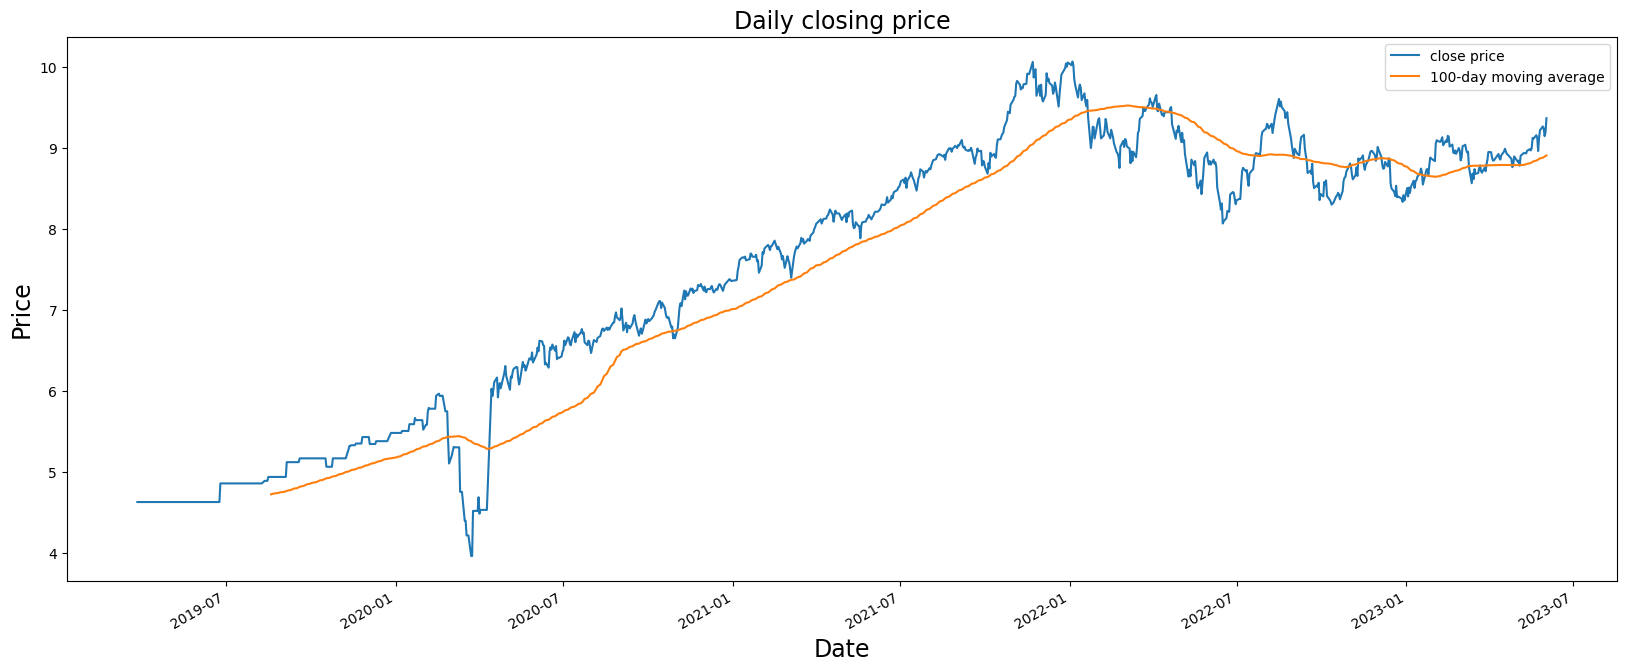

In [412]:
rolling_resolution = 100

plt.figure(figsize=(20,8))
plt.xlabel('Data', fontsize=17)
plt.ylabel('Price', fontsize=17)
plt.title('Daily closing price', fontsize=17)
#plt.grid(b=True, which='major', color='b', linestyle='-')

df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average')
#df[symbol].plot(legend=True, label='20-day VWAP')

plt.show()

### Prepare value de-normalized database and plot min, max, mean
Each year in seperate column

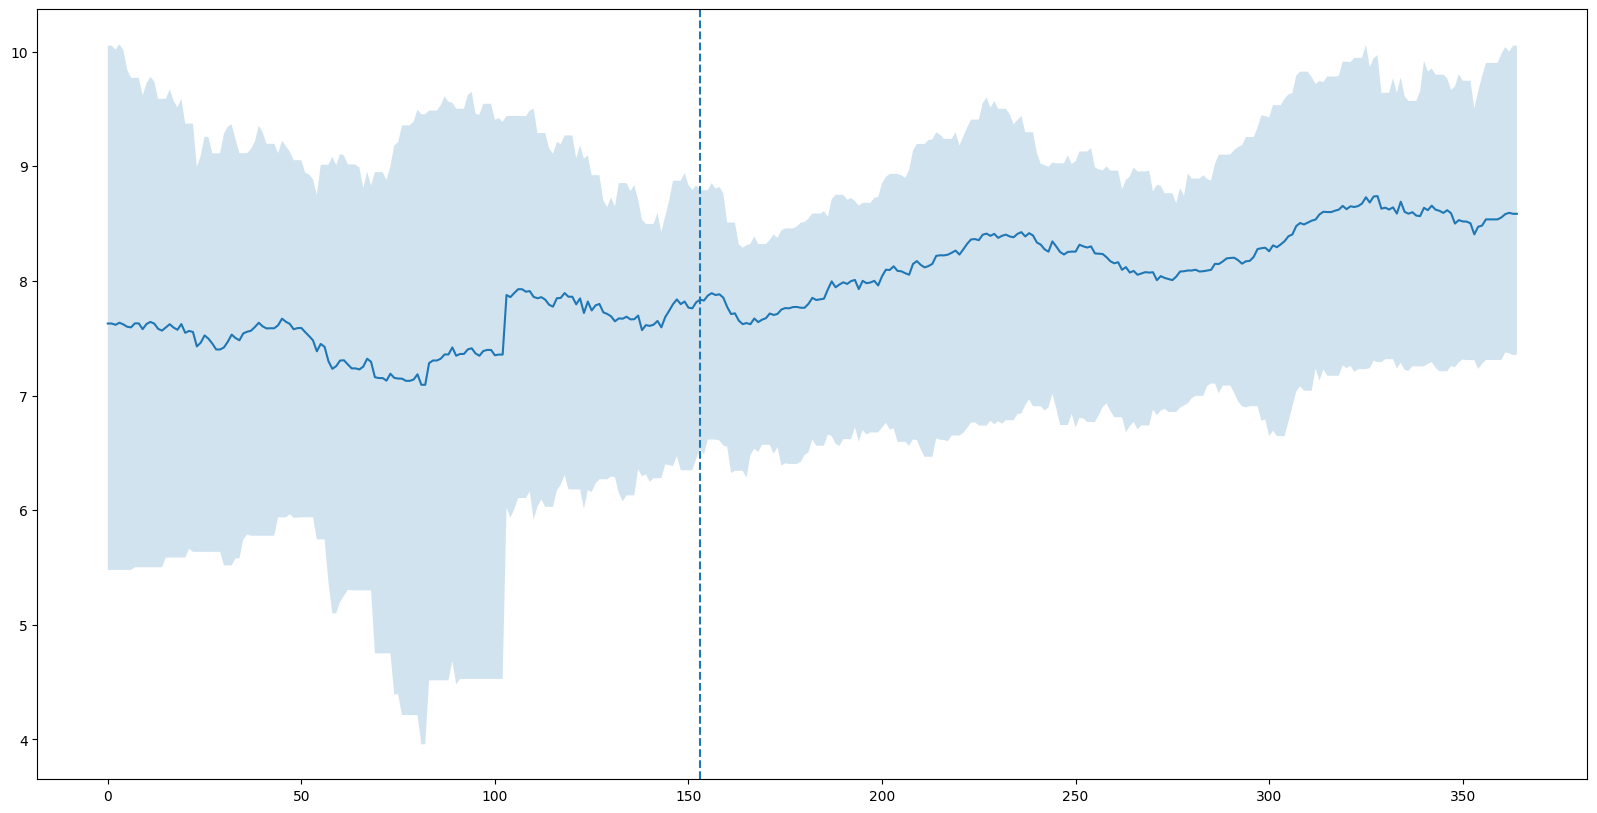

In [420]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values


resultDf = pd.DataFrame()
for year in list(set(df.index.year))[1:-1]:
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 365:                     # take a regular complete year
        resultDf[str(year)] = curYearValues
    elif curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
        resultDf[str(year)] = curYearValues

resultMean = resultDf.mean(axis=1)
resultMin = resultDf.min(axis=1)
resultMax = resultDf.max(axis=1)
resultDf['mean'] = resultMean
resultDf['min'] = resultMin
resultDf['max'] = resultMax


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(resultDf.index, resultDf['mean'], '-')
ax.fill_between(resultDf.index, resultDf['min'], resultDf['max'], alpha=0.2)
ax.axvline(dt.date.today().timetuple().tm_yday, linestyle='dashed')
     



### Get seasonality from data
And place into result

In [428]:
decompose = seasonal_decompose(df['Close'], model='additive', period=365)

lastYear=dt.date.today().year-1
resultDf['seasonal'] = decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].values

resultDf



,2020,2021,2022,mean,min,max,seasonal
0,5.478,7.354,10.052,7.628000,5.478,10.052,0.282412
1,5.478,7.354,10.052,7.628000,5.478,10.052,0.279219
2,5.478,7.354,10.018,7.616667,5.478,10.018,0.264677
3,5.478,7.363,10.064,7.635000,5.478,10.064,0.279804
4,5.478,7.368,10.016,7.620667,5.478,10.016,0.262092
...,...,...,...,...,...,...,...
360,7.310,9.980,8.371,8.553667,7.310,9.980,0.259761
361,7.376,10.040,8.331,8.582333,7.376,10.040,0.298487
362,7.368,10.000,8.413,8.593667,7.368,10.000,0.279280
363,7.354,10.052,8.349,8.585000,7.354,10.052,0.288799


### Plot out the seasonal data

<Axes: title={'center': 'Residual'}, xlabel='Date'>

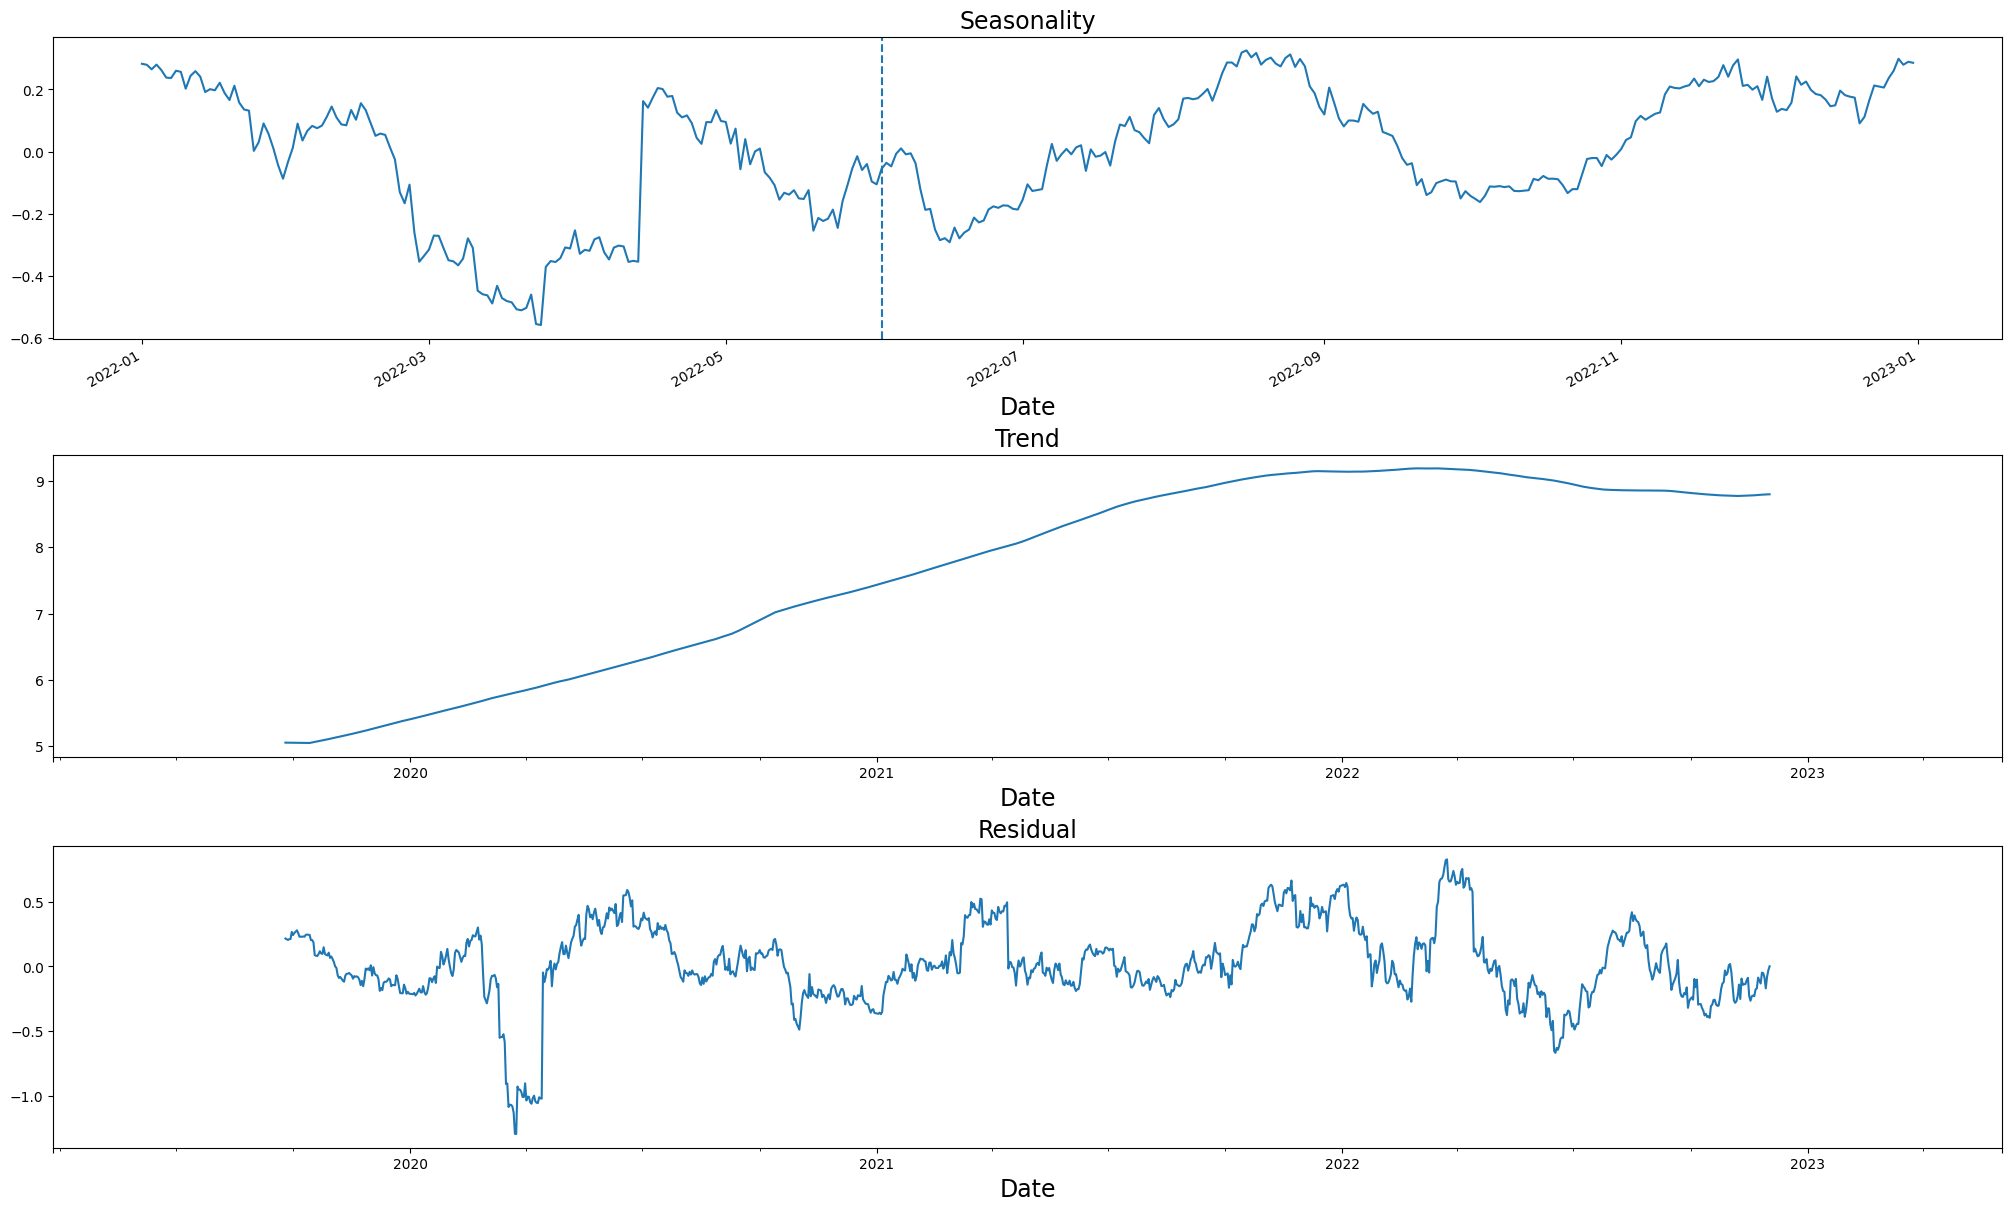

In [267]:
plt.figure(figsize=(20,12), layout='constrained')

plt.subplot(311)
plt.xlabel('Date', fontsize=17)
plt.title('Seasonality', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(year, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].plot()

plt.subplot(312)
plt.xlabel('Date', fontsize=17)
plt.title('Trend', fontsize=17)
decompose.trend.plot()

plt.subplot(313)
plt.xlabel('Date', fontsize=17)
plt.title('Residual', fontsize=17)
decompose.resid.plot()

